## Extracting CNN filter responses

This notebook demonstrates how to extract the learned features from a convolutional neural network and apply them to a MODIS granule.

### Run this notebook using Docker

This notebook can be run from inside a Docker container that comes with all dependencies installed.
If you have docker installed all you need to do is run:

    docker pull simonpf/cloud_collocations:latests
    docker run -it -p 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy             as np
import sys
sys.path.append("..")
plt.style.use("../data/notebook")

## Loading the full model

The full model is stored in `../models/cloud_net_simple_10.pckl`.

In [126]:
from cloud_collocations.cloud_net import CloudNetBase
cnn = CloudNetBase.load("../models/cloud_net_simple_10.pckl")

## Create a feature model

The feature model class extracts the convolutional layers from the CNN. By retaining only the convolutional layers it becomes possible to apply the network to input of any size. The output generated by the feature model is **decreased  in the spatial dimensions** but increased along the **image channel or filter dimension**. The model loaded here has 32 filters in the last convolutional layer.

In [132]:
cnn.model.layers[4].input_shape

(None, 32, 7, 7)

In [127]:
from cloud_collocations.cloud_net import FeatureModel
m = FeatureModel(cnn)

## Load a MODIS granule

We load a modis granule `cloud_collocation` package provides an interface to the ICARE data center which is used here. 

In [32]:
from cloud_collocations.formats import ModisMyd03, ModisMyd021km

modis_filename     = "../cache/MYD021KM.A2009213.1245.006.2012060003528.hdf"
modis_file         = ModisMyd021km(modis_filename)
modis_geo_filename = "../cache/MYD03.A2009213.1245.005.2009214170315.hdf"
modis_geo_file     = ModisMyd03(modis_geo_filename)

[-21.649885, 40.919586, 20.250069, 62.920322]
[0.45696039 0.35582941 0.16833071]


/home/simonpf/build/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:233: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
/home/simonpf/build/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:233: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):


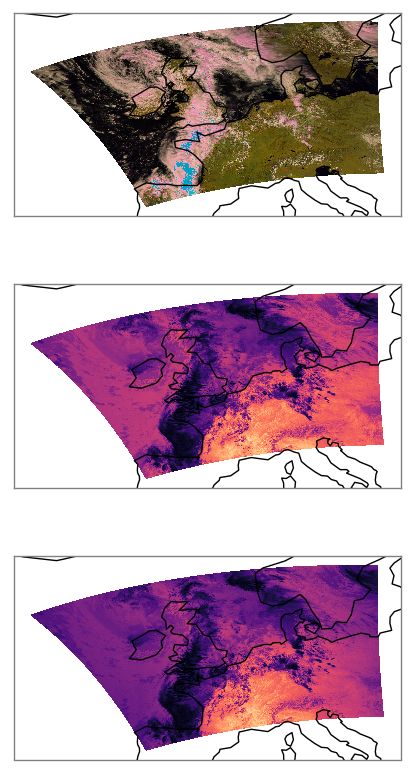

In [117]:
import matplotlib.gridspec as gridspec
from cloud_collocations.plots import plot_modis_granule_composite, plot_scalar_field
plt.figure(figsize = (5, 10))
gs = gridspec.GridSpec(3, 1)
plot_modis_granule_composite(modis_file, modis_geo_file, grid_spec = gs[0, 0])

lats = modis_geo_file.get_latitudes()
lons = modis_geo_file.get_longitudes()

plot_scalar_field(modis_file.data[30, :, :], lats, lons,  grid_spec = gs[1,0])
plot_scalar_field(modis_file.data[31, :, :], lats, lons, grid_spec = gs[2, 0])

## Applying the feature model

The original model was trained on the MODIS $11\mu$, and $12\mu$ channels, therefore also the feature model expects the input to have two channels along the first dimension.

In [71]:
filter_response = m.apply(modis_file.data[[30, 31], :, :])

In [79]:
from cloud_collocations.cloud_net import FeatureModel
m = FeatureModel(cnn)

In [84]:
lats_f = m.resample_coordinates(lats)
lons_f = m.resample_coordinates(lons)

### Plotting all features

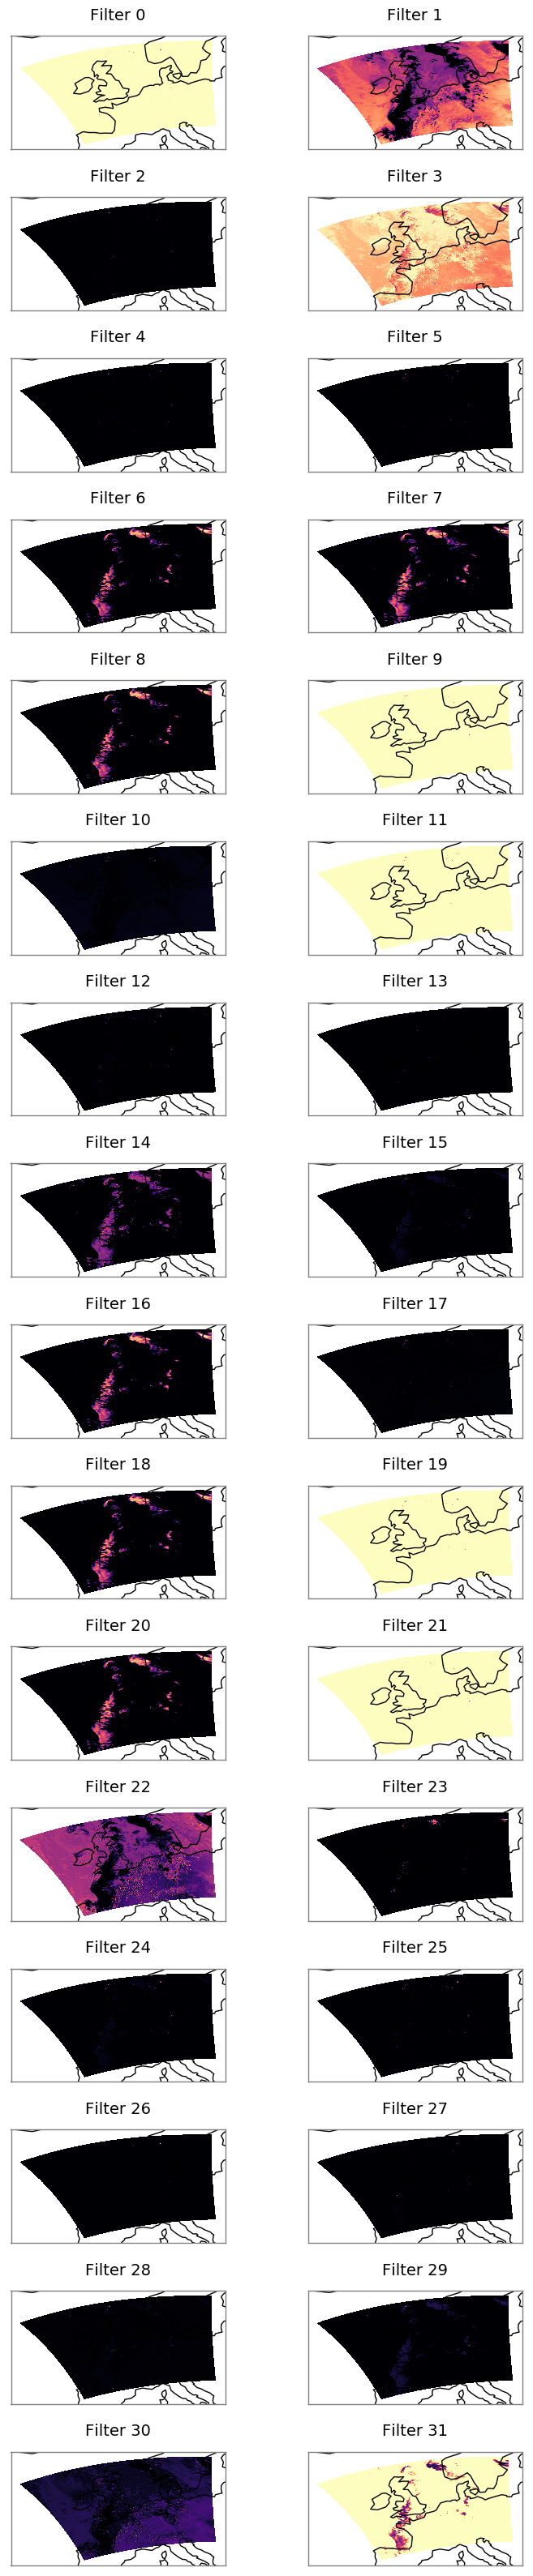

In [105]:
from matplotlib.colors import Normalize, LogNorm
f = plt.figure(figsize = (10, 32))
for i in range(32):
    
    f_max = np.max(np.abs(filter_response[0, i, :, :]))
    f_min = np.min(np.abs(filter_response[0, i, :, :]))
    
    plot_scalar_field(filter_response[0, i, :, :], lats_f, lons_f,
                      subplot = (16, 2, i + 1))
    ax = plt.gca()
    ax.set_title("Filter {0}".format(i))
    plt.tight_layout()

### Only interesting responses

Some of the filters do not seem to contain valuable information at least plotted in this way. Whether or not they contain valuable information for a retrieval remains to be seen.

Let's plot again the RGB and input granules as well as the more interesting filter responses, to have them side by side.

[-21.649885, 40.919586, 20.250069, 62.920322]


/home/simonpf/build/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:233: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
/home/simonpf/build/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:233: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):


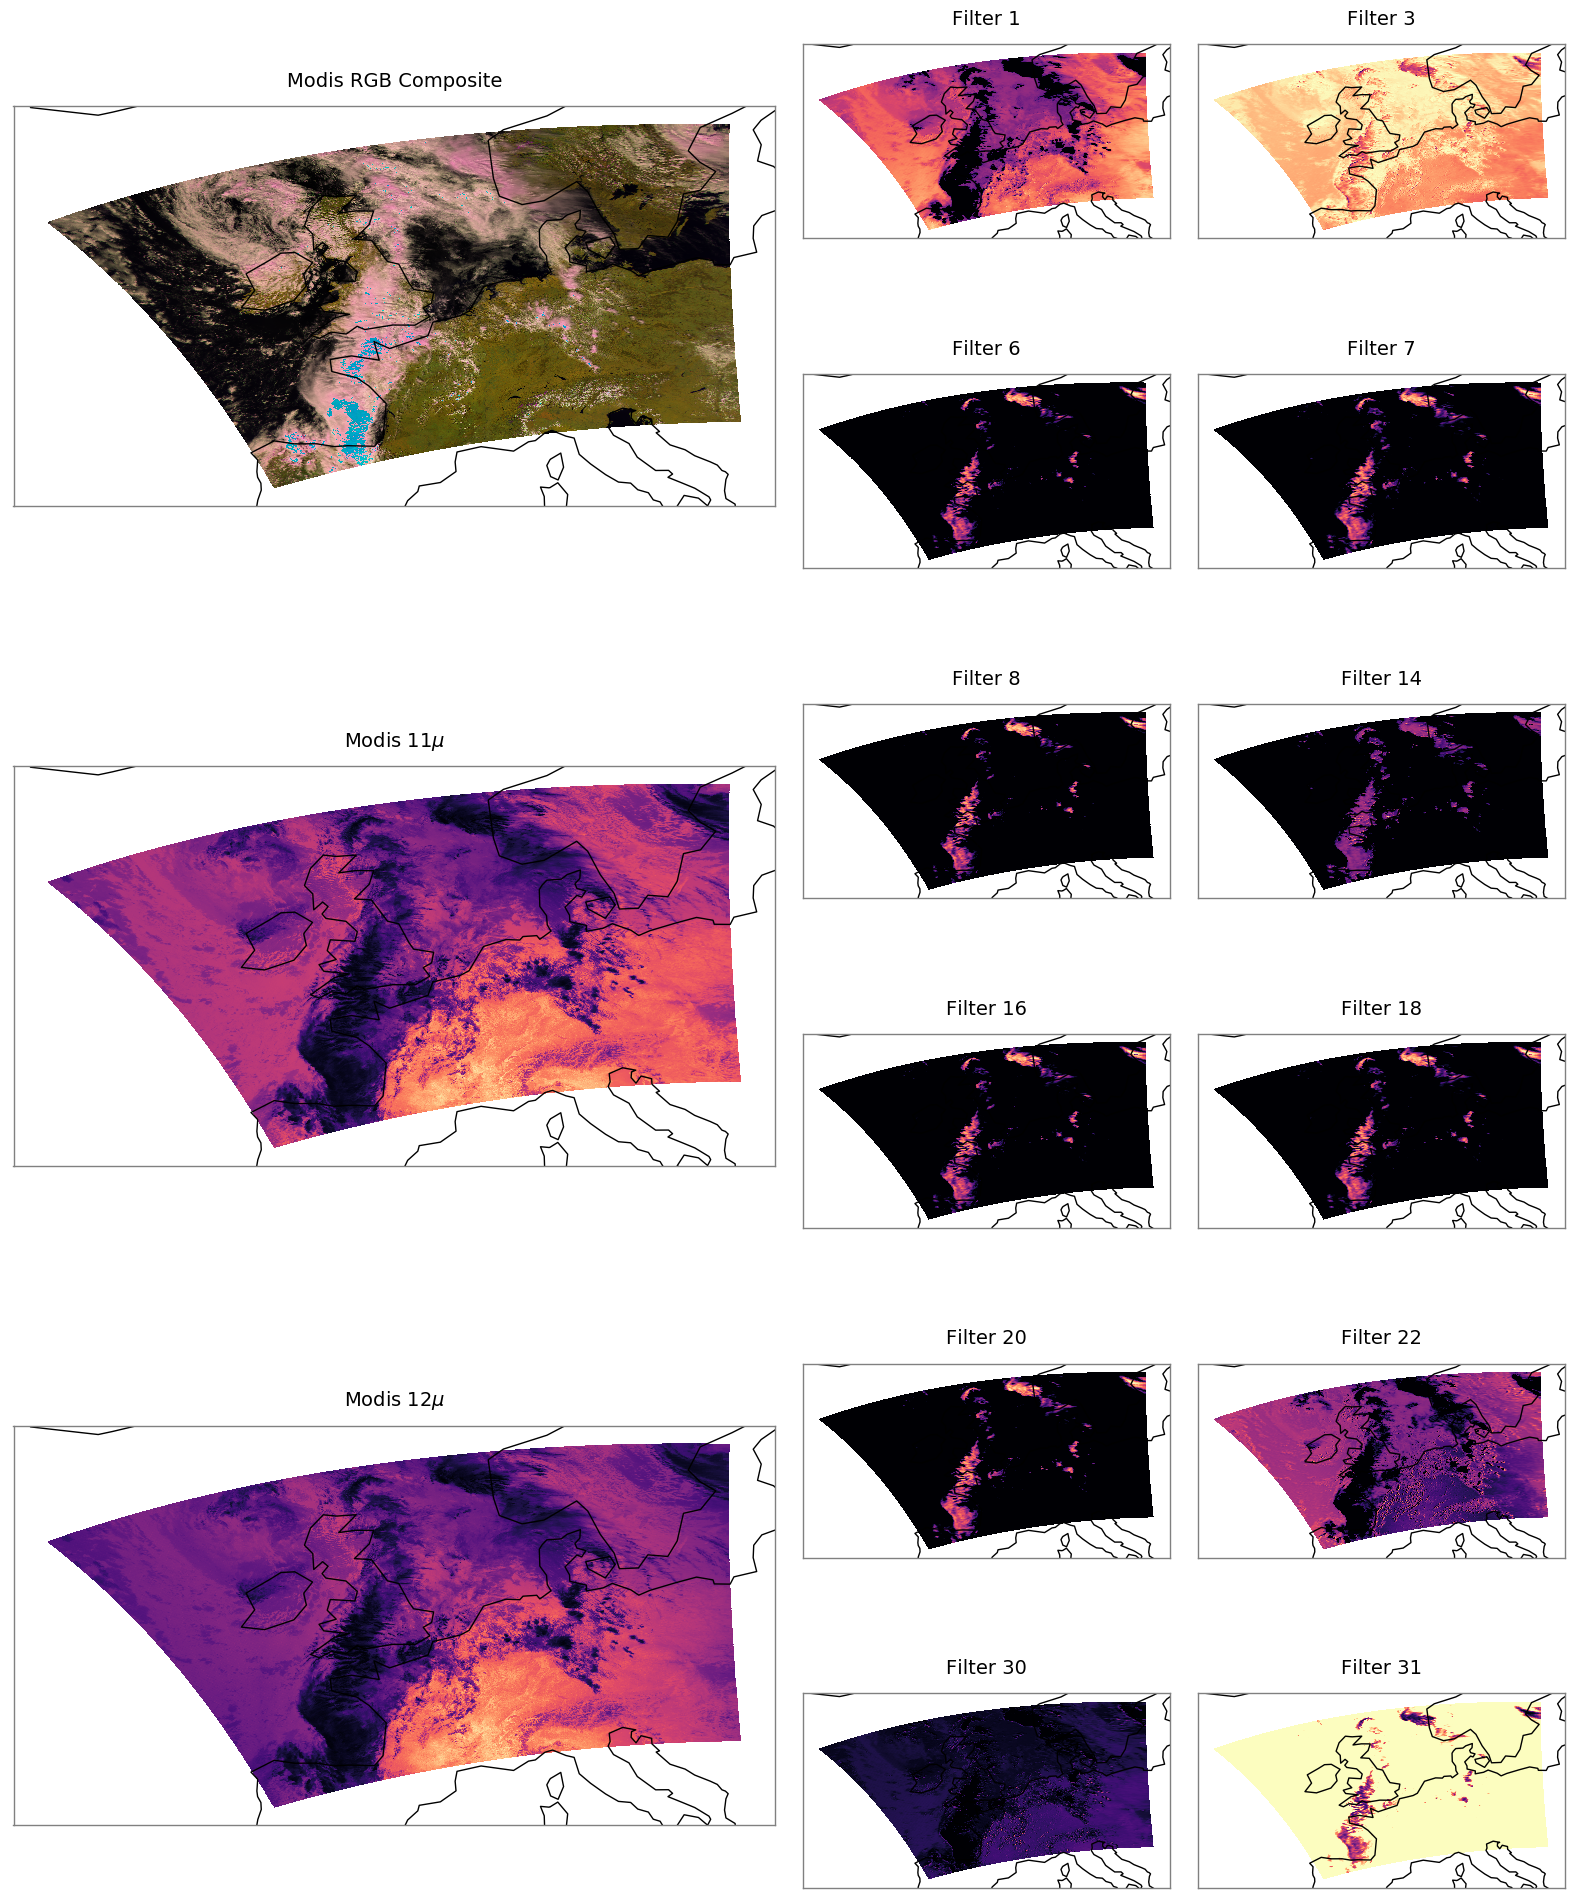

In [124]:
import matplotlib.gridspec as gridspec

plt.figure(figsize = (16, 20))
gs = gridspec.GridSpec(6, 4)

gs1 = gs[0:2, :2]
gs2 = gs[2:4, :2]
gs3 = gs[4:6, :2]

gss = [gs[i // 2, 2 + i % 2] for i in range(12)]

plot_modis_granule_composite(modis_file, modis_geo_file, grid_spec = gs1)
ax = plt.gca()
ax.set_title("Modis RGB Composite")

lats = modis_geo_file.get_latitudes()
lons = modis_geo_file.get_longitudes()

plot_scalar_field(modis_file.data[30, :, :], lats, lons,  grid_spec = gs2)
ax = plt.gca()
ax.set_title("Modis $11\mu$")

plot_scalar_field(modis_file.data[31, :, :], lats, lons, grid_spec = gs3)
ax = plt.gca()
ax.set_title("Modis $12\mu$")

inds = [1, 3, 6, 7, 8, 14, 16, 18, 20, 22, 30, 31]
for i, j in enumerate(inds):
    plot_scalar_field(filter_response[0, j, :, :], lats_f, lons_f, grid_spec = gss[i])
    ax = plt.gca()
    ax.set_title("Filter {0}".format(j))
    
plt.tight_layout()